# Preterm Birth Prediction Microbiome Model Framework

Challenge website:
https://www.synapse.org/#!Synapse:syn26133770/wiki/618018

In [1]:
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import sklearn as sk

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from collections import Counter,defaultdict, OrderedDict
from itertools import islice

%matplotlib inline
import matplotlib.pyplot as plt

# 1. Model Summary

The model framework is based on several different datasets and can be separated into two different stages.

## First stage model:

The **first stage model** contain four different models:
- LSTM: alpha diversity + CST categories + meta data;
- LSTM: phylotype data;
- LSTM: taxonomy data;
- KNN:  krdwide data.

The outputs of each above sub-model are two columns of class probabilities of "*preterm*" or "*not preterm*".

## Second stage model:

The **second stage model** simply uses a logistic regression model to summarize the prediction probabilities from first stage model. Since the prediction probabilities of binary classes for each observation are sum to one and hence coupled, we only use the prediction probability of class "*preterm*" in the second stage model.

# 2. Model Training

Each data set has been divided into the training, validation and testing set with the ratio of 0.6, 0.3 and 0.1. The training set is used to train model, the validation set is used to select the best model from the trained models and the testing set is used for checking the constructed model performance.

Since we have a two-stages model framework, the training set will be used twice in both building the first stage models and the second stage logistic regression model. 

(**Questions to check**: Maybe we can construct the logistic regression model with both the training and validation sets?*)


## 2.1. Read-in & clean data.

Here, we mainly have two criterion for data cleaning and filtering.
- 1). Average within each collection period;

    There are many cases of having multiple specimens collected from the same week and simply deleting them will be a huge sample lost. Average within each collection period can not only help save these specimens' information, but also it could help reduce the numer of zeros when we perform zero padding to construct the input of LSTM models. (Generally, the none zero values (observed) usually have at least 10% out of all observations to have a better performance.) The new variable, **collect_period**, is constructed based on the collected week of each specimen and both the time varying and not varying are averaged within each collection period. Rules of **collect_period** construction are:
    
    - **collect_period 1** is labeled if specimen collected before week 13;
    - **collect_period 2** is labeled if specimen collected between week 13 and week 24;
    - **collect_period 3** is labeled if specimen collected between week 25 and week 28;
    - **collect_period 4** is labeled if specimen collected between week 29 and week 32;
    - **collect_period 5** is labeled if specimen collected between after week 32;
    
    
    
- 2). Filtered out observations with collect_wk<=32;

    The training and Validation data sets will be limited to through 32 weeks for the preterm prediction and through 28 weeks for the early-preterm prediction.
    
**Questions**: Need to involve collect_wk<=28 as one end of collection period !!!

In [2]:
# data directory
meta_dir      = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/metadata_imputed1.csv'
alpha_dir     = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/training_data_2022-05-27/alpha_diversity/alpha_diversity.csv'
cst_dir       = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/training_data_2022-05-27/community_state_types/cst_valencia.csv'
krdwide_dir   = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/training_data_2022-05-27/pairwise_distance/krd_distance_wide.csv'
phylotype_dir = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/training_data_2022-05-27/phylotypes/phylotype_relabd.1e0.csv'
taxonomy_dir  = '/Users/mli171/Desktop/JHU/3Summer2022_JHU/DREAM/training_data_2022-05-27/taxonomy/taxonomy_relabd.family.csv'

**Questions**: The meta data imputation need to be involved.

### 2.1.1 Meta + alpha + cst datadata

In [3]:
meta_data = pd.DataFrame(pd.read_csv(meta_dir, delimiter=','))
meta_data = meta_data[['participant_id', 'project', 'delivery_wk', 'collect_wk', 'age_imp', 'race_imp']]
alpha_data = pd.DataFrame(pd.read_csv(alpha_dir, delimiter=','))
cst_data = pd.DataFrame(pd.read_csv(cst_dir, delimiter=','))

meta_data = pd.concat([meta_data, alpha_data['shannon'], cst_data['CST']], axis=1)
print(meta_data.shape)

for i in range(1,meta_data.shape[1]):
    if meta_data.iloc[:,i].dtypes == object:
        meta_data.iloc[:,i] = meta_data.iloc[:,i].astype('category').cat.codes + 1
        meta_data.iloc[:,i] = meta_data.iloc[:,i].astype('float64')

# create new variable 'collect_period'
meta_data['collect_period'] = 1
meta_data['collect_period'][(meta_data['collect_wk']>=17)  & (meta_data['collect_wk']<=20)] = 2
meta_data['collect_period'][(meta_data['collect_wk']>=21)  & (meta_data['collect_wk']<=28)] = 3
meta_data['collect_period'][(meta_data['collect_wk']>=29)  & (meta_data['collect_wk']<=32)] = 4
meta_data['collect_period'][(meta_data['collect_wk']>32)]                                   = 5

collect_period = meta_data['collect_period']
participant_id = meta_data['participant_id']

# create class label
meta_data['was_preterm'] = 1*(meta_data['delivery_wk'] < 37)
meta_data['was_early_preterm'] = 1*(meta_data['delivery_wk'] < 32)

# Filtered out observations with "collect_wk<=32" == "collect_period<=4" 
meta_data = meta_data[meta_data['collect_period']<=4]
# Average within each collection period
meta_data = meta_data.groupby(['participant_id', 'collect_period'], as_index = False).mean()
print(meta_data.shape)
print(meta_data['collect_period'].value_counts())

(3578, 8)
(1661, 11)
2    769
3    370
1    299
4    223
Name: collect_period, dtype: int64


/var/folders/xy/ccg9zpjj4sq_l6d6fypc_5740000gn/T/ipykernel_52612/202948611.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['collect_period'][(meta_data['collect_wk']>=17)  & (meta_data['collect_wk']<=20)] = 2
/var/folders/xy/ccg9zpjj4sq_l6d6fypc_5740000gn/T/ipykernel_52612/202948611.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['collect_period'][(meta_data['collect_wk']>=21)  & (meta_data['collect_wk']<=28)] = 3
/var/folders/xy/ccg9zpjj4sq_l6d6fypc_5740000gn/T/ipykernel_52612/202948611.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

### 2.1.2 Taxonomy OTU (RA) data (Family level)

In [4]:
taxonomy_data = pd.DataFrame(pd.read_csv(taxonomy_dir, delimiter=','))
taxonomy_data = pd.concat([participant_id, collect_period, taxonomy_data], axis=1)

# Filtered out observations with "collect_wk<=32" == "collect_period<=4" 
taxonomy_data = taxonomy_data[taxonomy_data['collect_period']<=4]
# Average within each collection period
taxonomy_data = taxonomy_data.groupby(['participant_id', 'collect_period'], as_index = False).mean()
print(taxonomy_data.shape)

(1661, 527)


### 2.1.3 Phylotype data  (.1e0)

In [5]:
phylotype_data = pd.DataFrame(pd.read_csv(phylotype_dir, delimiter=','))
phylotype_data = pd.concat([participant_id, collect_period, phylotype_data], axis=1)

# Filtered out observations with "collect_wk<=32" == "collect_period<=4" 
phylotype_data = phylotype_data[phylotype_data['collect_period']<=4]
# Average within each collection period
phylotype_data = phylotype_data.groupby(['participant_id', 'collect_period'], as_index = False).mean()
print(phylotype_data.shape)

(1661, 1846)


### 2.1.4 KRD pairwise distance data (wide)

In [6]:
krd_data = pd.DataFrame(pd.read_csv(krdwide_dir, delimiter=','))

krd_data = pd.concat([participant_id, collect_period, krd_data], axis=1)
# Filtered out observations with "collect_wk<=32" == "collect_period<=4" 
krd_data = krd_data[krd_data['collect_period']<=4]
# Average within each collection period
krd_data = krd_data.groupby(['participant_id', 'collect_period'], as_index = False).mean()
krd_data = krd_data.drop(['participant_id', 'collect_period'], axis=1).T
# set the index same in order to concate columns
participant_id.index = krd_data.index
collect_period.index = krd_data.index
krd_data = pd.concat([participant_id, collect_period, krd_data], axis=1)
# Filtered out observations with "collect_wk<=32" == "collect_period<=4" 
krd_data = krd_data[krd_data['collect_period']<=4]
krd_data = krd_data.groupby(['participant_id', 'collect_period'], as_index = False).mean()
print(krd_data.shape)

(1661, 1663)


### 2.1.5 Dimension summary of each dataset

In [7]:
uniquenames, counts = np.unique(meta_data["participant_id"], return_counts=True)
subjects = list(uniquenames)
print("##################################")
print("# of subjects = ", len(subjects))
print("# of samples  = ", meta_data.shape[0])
print("##################################")
print("# of meta data features    = ", meta_data.shape[1])
print("# of taxonnomy features    = ", len(list(taxonomy_data)))
print("# of phylotype features    = ", len(list(phylotype_data)))
print("# of modified krd features = ", len(list(krd_data)))

##################################
# of subjects =  1214
# of samples  =  1661
##################################
# of meta data features    =  11
# of taxonnomy features    =  527
# of phylotype features    =  1846
# of modified krd features =  1663


## 2.2. Data sets splitter

Since we have multiple datasets, we will use the index of subjects to guide training, validation and testing set spliter. Also noted, since there are different number of records for each patient, the dimension of train and testing data sets are not follow the proportion 0.6, but the patients will follow.

In [8]:
def dataset_splitID(meta_data, subjects, prop, myseed):
    
    if myseed != None:
        random.seed(myseed)
        
    numsubjects = len(subjects)

    subjects_shuffle = random.sample(subjects, numsubjects)
    
    train_subjects = subjects_shuffle[0:(int(len(subjects)*prop[0])+1)] 
    valid_subjects = subjects_shuffle[(int(len(subjects)*prop[0])+2):(int(len(subjects)*(prop[0]+prop[1]))+1)]
    test_subjects = subjects_shuffle[(int(len(subjects)*(prop[0]+prop[1]))+2):numsubjects]
    
    splitID_train = meta_data['participant_id'].isin(train_subjects)
    splitID_valid = meta_data['participant_id'].isin(valid_subjects)
    splitID_test = meta_data['participant_id'].isin(test_subjects)
    
    return splitID_train, splitID_valid, splitID_test

In [9]:
# set myseed=None to have complete random state
splitID_train, splitID_valid, splitID_test = dataset_splitID(meta_data, subjects, prop = [0.6, 0.3, 0.1], myseed=0)

# apply to each data sets
meta_data_train = meta_data[splitID_train]
meta_data_valid = meta_data[splitID_valid]
meta_data_test  = meta_data[splitID_test]
print("################ meta_data")
print(meta_data_train.shape)
print(meta_data_valid.shape)
print(meta_data_test.shape)

taxonomy_data_train = taxonomy_data[splitID_train]
taxonomy_data_valid = taxonomy_data[splitID_valid]
taxonomy_data_test  = taxonomy_data[splitID_test]
print("################ taxonomy_data")
print(taxonomy_data_train.shape)
print(taxonomy_data_valid.shape)
print(taxonomy_data_test.shape)

phylotype_data_train = phylotype_data[splitID_train]
phylotype_data_valid = phylotype_data[splitID_valid]
phylotype_data_test  = phylotype_data[splitID_test]
print("################ phylotype_data")
print(phylotype_data_train.shape)
print(phylotype_data_valid.shape)
print(phylotype_data_test.shape)

krd_data_train = krd_data[splitID_train]
krd_data_valid = krd_data[splitID_valid]
krd_data_test  = krd_data[splitID_test]
print("################ krd_data")
print(krd_data_train.shape)
print(krd_data_valid.shape)
print(krd_data_test.shape)

################ meta_data
(1006, 11)
(495, 11)
(158, 11)
################ taxonomy_data
(1006, 527)
(495, 527)
(158, 527)
################ phylotype_data
(1006, 1846)
(495, 1846)
(158, 1846)
################ krd_data
(1006, 1663)
(495, 1663)
(158, 1663)


## 2.3. Data Reshaper for LSTM models

### Inputs

In [10]:
def Data_Reshaper_Input(data, seq_length):
    
    numsubjects = len(np.unique(data['participant_id']))
    myvary = list(data.columns.values)[2:data.shape[1]]
    num_covariates = len(myvary)
    
    myinput = np.zeros((numsubjects, seq_length, num_covariates), dtype=np.float32)
    for i in range(num_covariates):
        data_wide = data.pivot_table(index=['participant_id'], columns='collect_period', values=myvary[i])
        data_wide = data_wide.sort_index(axis=1)
        data_wide = data_wide.fillna(0)
        tmpindex = data_wide._get_numeric_data().columns.values - 1
        tmpindex = tmpindex.tolist()
        # time varying variables need to impute all and no records are denoted as 0
        for j in range(numsubjects):
                myinput[j,tmpindex,i] = data_wide.iloc[[j]]
    return myinput

**Warning**: *Longer running time*

In [11]:
metatrain_input = Data_Reshaper_Input(data=meta_data_train, seq_length=4)
metavalid_input = Data_Reshaper_Input(data=meta_data_valid, seq_length=4)
metatest_input  = Data_Reshaper_Input(data=meta_data_test, seq_length=4)
print(metatrain_input.shape)
print(metavalid_input.shape)
print(metatest_input.shape)

taxonomytrain_input = Data_Reshaper_Input(data=taxonomy_data_train, seq_length=4)
taxonomyvalid_input = Data_Reshaper_Input(data=taxonomy_data_valid, seq_length=4)
taxonomytest_input  = Data_Reshaper_Input(data=taxonomy_data_test, seq_length=4)
print(taxonomytrain_input.shape)
print(taxonomyvalid_input.shape)
print(taxonomytest_input.shape)

phylotypetrain_input = Data_Reshaper_Input(data=phylotype_data_train, seq_length=4)
phylotypevalid_input = Data_Reshaper_Input(data=phylotype_data_valid, seq_length=4)
phylotypetest_input = Data_Reshaper_Input(data=phylotype_data_test, seq_length=4)
print(phylotypetrain_input.shape)
print(phylotypevalid_input.shape)
print(phylotypetest_input.shape)

(729, 4, 9)
(363, 4, 9)
(120, 4, 9)
(729, 4, 525)
(363, 4, 525)
(120, 4, 525)
(729, 4, 1844)
(363, 4, 1844)
(120, 4, 1844)


### Output
##### Data_Reshaper_Output_ManytoMany_0
- reshape patients class labels from long to wide form;
- output array formulation, **two** columns;
- Label smoothing on 1stColumn;
    - was_preterm: 0.5, 0.67, 0.83, 1;
    - not was_preterm: 0.5, 0.33, 0.17, 0;
    - no missing values indication;
- Label smoothing on 2ndColumn: 1 - 1stColumn;

In [12]:
def Data_Reshaper_Output_ManytoMany_0(data, seq_length, classlabel):

    num_samples = len(np.unique(data['participant_id']))
    
    data_wide = data.pivot_table(index=['participant_id'], columns='collect_period', values=classlabel)
    data_wide = data_wide.sort_index(axis=1)
    
    myoutput = np.zeros((num_samples, seq_length, 2), dtype=np.float32)
    for i in range(num_samples):
        tmp = data_wide.iloc[i,:]
        
        if np.nanmax(tmp) == 1:
            # label linear smoonthing from 0.5 to 1
            # fill all position 1 to have final labels equal to 1
            myoutput[i,:,0].fill(1)
            myoutput[i,:,0] = np.linspace(start=0.5, stop=1, num=seq_length)
        else:
            # label linear smoonthing from 0.5 to 0
            # fill all position 0 to have final labels equal to 0 
            #     but array alrady initialize as 0
            myoutput[i,:,0] = np.linspace(start=0.5, stop=0, num=seq_length)
            
        myoutput[i,:,1] = 1 - myoutput[i,:,0]
    return myoutput

In [13]:
mytrain_output_0 = Data_Reshaper_Output_ManytoMany_0(data=meta_data_train, seq_length=4, classlabel="was_preterm")
print(mytrain_output_0.shape)
print(mytrain_output_0[2])

myvalid_output_0 = Data_Reshaper_Output_ManytoMany_0(data=meta_data_valid, seq_length=4, classlabel="was_preterm")
print(myvalid_output_0.shape)
print(myvalid_output_0[4])

mytest_output_0 = Data_Reshaper_Output_ManytoMany_0(data=meta_data_test, seq_length=4, classlabel="was_preterm")
print(mytest_output_0.shape)
print(mytest_output_0[4])

(729, 4, 2)
[[0.5        0.5       ]
 [0.33333334 0.6666666 ]
 [0.16666667 0.8333333 ]
 [0.         1.        ]]
(363, 4, 2)
[[0.5        0.5       ]
 [0.33333334 0.6666666 ]
 [0.16666667 0.8333333 ]
 [0.         1.        ]]
(120, 4, 2)
[[0.5        0.5       ]
 [0.6666667  0.3333333 ]
 [0.8333333  0.16666669]
 [1.         0.        ]]


## 2.4. Phylotype LSTM

In [14]:
class Model_phylotype(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, seq_len, n_layers, fc_size, dropoutrate):
        super(Model_phylotype, self).__init__()

        # Defining some parameters
        self.input_size  = input_size      # number of input node
        self.output_size = output_size     # number of output node
        self.seq_len     = seq_len         # seq_len: number of timepoints (collection period)
        self.fc_size     = fc_size         # size of the fully connected net
        self.n_layers    = n_layers        # number of LSTM/RNN layers
        self.hidden_dim  = hidden_dim      # hidden size of LSTM/RNN, also the size of fully connected NN 1
        
        # (1) RNN layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc_1 = nn.Linear(in_features=hidden_dim*seq_len, out_features=fc_size[0], bias=False)
        self.fc_2 = nn.Linear(in_features=fc_size[0], out_features=fc_size[1], bias=False)
        self.fc_3 = nn.Linear(in_features=fc_size[1], out_features=fc_size[2], bias=False)
        self.fc_4 = nn.Linear(in_features=fc_size[2], out_features=output_size, bias=False)
        # (5) ReLU layer (Fix Vanishing Gradients ???)
        self.relu = nn.ReLU()
        
        # define dropout proportion to prevent overfitting
        self.dropout = nn.Dropout(dropoutrate)

    
    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        batch_size = x.size(0)
        h0 = self.init_hidden(batch_size)
        c0 = self.init_hidden(batch_size)
        # Propagate input through LSTM/RNN
        # outp, hidden = self.rnn(x, h0)     # lstm/rnn with input, hidden, and internal state
        outp, hidden = self.lstm(x, (h0, c0))   # lstm/rnn with input, hidden, and internal state
        
        outp = outp.reshape(outp.shape[0], -1)  # reshaping the data for Dense layer next
        
        outp = self.relu(outp)   # relu
        outp = self.dropout(outp)# dropout
        outp = self.fc_1(outp)   # first Dense
        outp = self.relu(outp)   # relu
        outp = self.dropout(outp)# dropout
        outp = self.fc_2(outp)   # 2nd Dense
        outp = self.relu(outp)   # relu
        outp = self.dropout(outp)# dropout
        outp = self.fc_3(outp)   # 3rd Output
        outp = self.relu(outp)   # relu
        outp = self.dropout(outp)# dropout
        outp = self.fc_4(outp)   # 4th Output
        
        return outp, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

In [15]:
def RNNtrain_phylotype(model, device, criterion, optimizer, mytrain_input, mytrain_output, myvalid_input, myvalid_output, max_epochs, batch_size, verbose=True):
    
    model = model.to(device)
    
    # Track the value of the loss function and model accuracy across epochs
    history_train_valid = {'TrainLoss': [], 'TrainAcc': [], 'TrainAUC': [],
                           'ValidLoss': [], 'ValidAcc': [], 'ValidAUC': []}
    
    # Same reshaped Validation set for each epoch
    myvalid_input  = torch.from_numpy(myvalid_input).float().to(device)
    myvalid_output = torch.from_numpy(myvalid_output).float().to(device)
    
    valid_loss_min = np.inf
    valid_losses = []
    
    for epoch in range(max_epochs):

        #-------------- Batch-wise training model --------------#
        model.train()
        # train_loss = 0.0
        train_num_correct = 0
        train_prob = []
        for batch_idx in range(0, mytrain_input.shape[0], batch_size):
            # subset a batch of sequences and class labels
            tmpindex = list(range(batch_idx, min(batch_idx+batch_size, mytrain_input.shape[0])))
            mytrain_input_batch  = mytrain_input[tmpindex,:]
            mytrain_output_batch = mytrain_output[tmpindex,:]
            mytrain_input_batch  = torch.from_numpy(mytrain_input_batch).float().to(device)
            mytrain_output_batch = torch.from_numpy(mytrain_output_batch).float().to(device)
            # forward pass of RNN model
            output, hidden = model(mytrain_input_batch)
            output = output.reshape((mytrain_output_batch.shape))
            output_prob = nn.functional.softmax(output, dim=2)
            loss = criterion(output_prob, mytrain_output_batch)
            # Clear existing gradients from previous epoch
            optimizer.zero_grad()
            # Does backpropagation and calculates gradients
            loss.backward()
            # Updates the weights accordingly
            optimizer.step()
            # Number correct prediction on trainning set collection
            tmppred = 1*(output_prob[:,3,0] > 0.5)
            train_num_correct += sum(1*(tmppred == mytrain_output_batch[:,3,0]))
            # Training function loss collection
            # train_loss += loss.item()
            train_prob = np.concatenate((train_prob, output_prob[:,3,0].cpu().detach().numpy()), axis=None)
            
        train_acc = (float(train_num_correct) / len(mytrain_output))*100
        train_auc = metrics.roc_auc_score(mytrain_output[:,3,0], train_prob)
        
        model.eval()
        
        # Training loss calculation
        tmpmytrain_input  = torch.from_numpy(mytrain_input).float().to(device)
        tmpmytrain_output = torch.from_numpy(mytrain_output).float().to(device)
        tmpoutputtrain, tmphidden = model(tmpmytrain_input)
        tmpoutputtrain = tmpoutputtrain.reshape((tmpmytrain_output.shape))
        tmpoutputtrain_prob = nn.functional.softmax(tmpoutputtrain, dim=2)
        train_loss = criterion(tmpoutputtrain_prob, tmpmytrain_output)
        
        history_train_valid['TrainLoss'].append(train_loss.item())
        history_train_valid['TrainAcc'].append(train_acc)
        history_train_valid['TrainAUC'].append(train_auc)
        

        #--------------       Validate model      --------------#
        outputvalid, hidden = model(myvalid_input)
        outputvalid = outputvalid.reshape((myvalid_output.shape))
        outputvalid_prob = nn.functional.softmax(outputvalid, dim=2)
        # validation loss
        valid_loss = criterion(outputvalid_prob, myvalid_output)
        # Number correct prediction on trainning set collection
        tmppredprob = outputvalid_prob[:,3,0].cpu().detach().numpy()
        tmppred = 1*(tmppredprob > 0.5)
        tmpobs = myvalid_output[:,3,0].cpu().detach().numpy()
        valid_num_correct = sum(1*(tmppred == tmpobs))
        valid_acc = (float(valid_num_correct) / len(myvalid_output))*100
        valid_auc = metrics.roc_auc_score(tmpobs, tmppredprob)
        
        history_train_valid['ValidLoss'].append(valid_loss.item())
        history_train_valid['ValidAcc'].append(valid_acc)
        history_train_valid['ValidAUC'].append(valid_auc)
        
        if verbose or epoch + 1 == max_epochs:
            print(f'[E {epoch + 1}/{max_epochs}]'
                  f" T.Loss: {history_train_valid['TrainLoss'][-1]:.4f}, T.Acc: {history_train_valid['TrainAcc'][-1]:2.2f}, T.AUC: {history_train_valid['TrainAUC'][-1]:.4f}"
                  f" V.Loss: {history_train_valid['ValidLoss'][-1]:.4f}, V.Acc: {history_train_valid['ValidAcc'][-1]:2.2f}, V.AUC: {history_train_valid['ValidAUC'][-1]:.4f};")
        
        valid_losses.append(valid_loss.item())
        # start to considering early-stop after 10 epoch
        if epoch > 10:
            if np.mean(valid_losses) > valid_loss_min:
                print("Stopping here!")
                break
                # torch.save(model.state_dict(), './state_dict.pt')
                # print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
            valid_loss_min = np.mean(valid_losses)
            
    return history_train_valid, epoch

**Early-stopping prevent overfitting training set**:

- After 10 epoches, if the average validation AUC value of the latest 10 epoches from $i^{th}$ iteration is smaller than the average of the latest 10 epoches from $(i-1)^{th}$ iteration, the LSTM training will stop.

- dropout rate could also help prevent overfitting

#### Phylotype LSTM hyperparameters

In [16]:
mytrain_input  = phylotypetrain_input
mytrain_output = mytrain_output_0

myvalid_input  = phylotypevalid_input
myvalid_output = myvalid_output_0

input_size  = mytrain_input.shape[2]    # number of features
output_size = mytrain_output.shape[2]*4 # depend on the model
seq_len     = 4
hidden_dim  = 128
n_layers    = 1
fc_size     = [128, 64, 32]

dropoutrate = 0.15
lr         = 0.001
max_epochs = 100
batch_size = 50

# Automatically determine the device that PyTorch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_phylotype = Model_phylotype(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, seq_len=seq_len, n_layers=n_layers, fc_size=fc_size, dropoutrate=dropoutrate)
criterion = nn.MSELoss() # mean-squared error multiple values (not 0 or 1)
optimizer = torch.optim.Adam(model_phylotype.parameters(), lr=lr) 

TrainHistory, stop_epoch = RNNtrain_phylotype(model_phylotype, device, criterion, optimizer, mytrain_input, mytrain_output, myvalid_input, myvalid_output, max_epochs, batch_size, verbose=True)

[E 1/100] T.Loss: 0.0967, T.Acc: 62.00, T.AUC: 0.6050 V.Loss: 0.0968, V.Acc: 65.84, V.AUC: 0.5772;
[E 2/100] T.Loss: 0.0877, T.Acc: 69.27, T.AUC: 0.6423 V.Loss: 0.0899, V.Acc: 65.84, V.AUC: 0.5790;
[E 3/100] T.Loss: 0.0847, T.Acc: 69.27, T.AUC: 0.6004 V.Loss: 0.0923, V.Acc: 65.84, V.AUC: 0.5938;
[E 4/100] T.Loss: 0.0829, T.Acc: 69.27, T.AUC: 0.3734 V.Loss: 0.0871, V.Acc: 65.84, V.AUC: 0.6116;
[E 5/100] T.Loss: 0.0818, T.Acc: 69.27, T.AUC: 0.5846 V.Loss: 0.0873, V.Acc: 65.84, V.AUC: 0.6218;
[E 6/100] T.Loss: 0.0815, T.Acc: 69.27, T.AUC: 0.5112 V.Loss: 0.0876, V.Acc: 65.84, V.AUC: 0.6276;
[E 7/100] T.Loss: 0.0813, T.Acc: 69.27, T.AUC: 0.4771 V.Loss: 0.0870, V.Acc: 65.84, V.AUC: 0.6320;
[E 8/100] T.Loss: 0.0811, T.Acc: 69.27, T.AUC: 0.5098 V.Loss: 0.0869, V.Acc: 65.84, V.AUC: 0.6353;
[E 9/100] T.Loss: 0.0808, T.Acc: 69.27, T.AUC: 0.5186 V.Loss: 0.0870, V.Acc: 65.84, V.AUC: 0.6364;
[E 10/100] T.Loss: 0.0805, T.Acc: 69.27, T.AUC: 0.5154 V.Loss: 0.0866, V.Acc: 65.84, V.AUC: 0.6371;
[E 11/100

## 2.5. Taxonomy LSTM

In [17]:
class Model_taxonomy(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, seq_len, n_layers, fc_size, dropoutrate):
        super(Model_taxonomy, self).__init__()

        # Defining some parameters
        self.input_size  = input_size      # number of input node
        self.output_size = output_size     # number of output node
        self.seq_len     = seq_len         # seq_len: number of timepoints (collection period)
        self.fc_size     = fc_size         # size of the fully connected net
        self.n_layers    = n_layers        # number of LSTM/RNN layers
        self.hidden_dim  = hidden_dim      # hidden size of LSTM/RNN, also the size of fully connected NN 1
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc_1 = nn.Linear(in_features=hidden_dim*seq_len, out_features=fc_size[0], bias=False)
        self.fc_2 = nn.Linear(in_features=fc_size[0], out_features=fc_size[1], bias=False)
        self.fc_3 = nn.Linear(in_features=fc_size[1], out_features=fc_size[2], bias=False)
        self.fc_4 = nn.Linear(in_features=fc_size[2], out_features=output_size, bias=False)
        self.relu = nn.ReLU()
        
        # define dropout proportion to prevent overfitting
        self.dropout = nn.Dropout(dropoutrate)

    
    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        batch_size = x.size(0)
        h0 = self.init_hidden(batch_size)
        c0 = self.init_hidden(batch_size)
        # Propagate input through LSTM/RNN
        # outp, hidden = self.rnn(x, h0)     # lstm/rnn with input, hidden, and internal state
        outp, hidden = self.lstm(x, (h0, c0))   # lstm/rnn with input, hidden, and internal state
        
        outp = outp.reshape(outp.shape[0], -1)  # reshaping the data for Dense layer next
        
        outp = self.relu(outp)   # relu
        outp = self.dropout(outp)# dropout
        outp = self.fc_1(outp)   # first Dense
        outp = self.relu(outp)   # relu
        outp = self.dropout(outp)# dropout
        outp = self.fc_2(outp)   # 2nd Dense
        outp = self.relu(outp)   # relu
        outp = self.dropout(outp)# dropout
        outp = self.fc_3(outp)   # 3rd Output
        outp = self.relu(outp)   # relu
        outp = self.dropout(outp)# dropout
        outp = self.fc_4(outp)   # 4th Ouuput
        
        return outp, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

In [18]:
def RNNtrain_taxonomy(model, device, criterion, optimizer, mytrain_input, mytrain_output, myvalid_input, myvalid_output, max_epochs, batch_size, verbose=True):
    
    model = model.to(device)
    
    # Track the value of the loss function and model accuracy across epochs
    history_train_valid = {'TrainLoss': [], 'TrainAcc': [], 'TrainAUC': [],
                           'ValidLoss': [], 'ValidAcc': [], 'ValidAUC': []}
    
    # Same reshaped Validation set for each epoch
    myvalid_input  = torch.from_numpy(myvalid_input).float().to(device)
    myvalid_output = torch.from_numpy(myvalid_output).float().to(device)
    
    valid_loss_min = np.inf
    valid_losses = []
    
    for epoch in range(max_epochs):

        #-------------- Batch-wise training model --------------#
        model.train()
        # train_loss = 0.0
        train_num_correct = 0
        train_prob = []
        for batch_idx in range(0, mytrain_input.shape[0], batch_size):
            # subset a batch of sequences and class labels
            tmpindex = list(range(batch_idx, min(batch_idx+batch_size, mytrain_input.shape[0])))
            mytrain_input_batch  = mytrain_input[tmpindex,:]
            mytrain_output_batch = mytrain_output[tmpindex,:]
            mytrain_input_batch  = torch.from_numpy(mytrain_input_batch).float().to(device)
            mytrain_output_batch = torch.from_numpy(mytrain_output_batch).float().to(device)
            # forward pass of RNN model
            output, hidden = model(mytrain_input_batch)
            output = output.reshape((mytrain_output_batch.shape))
            output_prob = nn.functional.softmax(output, dim=2)
            loss = criterion(output_prob, mytrain_output_batch)
            # Clear existing gradients from previous epoch
            optimizer.zero_grad()
            # Does backpropagation and calculates gradients
            loss.backward()
            # Updates the weights accordingly
            optimizer.step()
            # Number correct prediction on trainning set collection
            tmppred = 1*(output_prob[:,3,0] > 0.5)
            train_num_correct += sum(1*(tmppred == mytrain_output_batch[:,3,0]))
            # Training function loss collection
            # train_loss += loss.item()
            train_prob = np.concatenate((train_prob, output_prob[:,3,0].cpu().detach().numpy()), axis=None)
            
        train_acc = (float(train_num_correct) / len(mytrain_output))*100
        train_auc = metrics.roc_auc_score(mytrain_output[:,3,0], train_prob)
        
        model.eval()
        
        # Training loss calculation
        tmpmytrain_input  = torch.from_numpy(mytrain_input).float().to(device)
        tmpmytrain_output = torch.from_numpy(mytrain_output).float().to(device)
        tmpoutputtrain, tmphidden = model(tmpmytrain_input)
        tmpoutputtrain = tmpoutputtrain.reshape((tmpmytrain_output.shape))
        tmpoutputtrain_prob = nn.functional.softmax(tmpoutputtrain, dim=2)
        train_loss = criterion(tmpoutputtrain_prob, tmpmytrain_output)
        
        history_train_valid['TrainLoss'].append(train_loss.item())
        history_train_valid['TrainAcc'].append(train_acc)
        history_train_valid['TrainAUC'].append(train_auc)
        

        #--------------       Validate model      --------------#
        outputvalid, hidden = model(myvalid_input)
        outputvalid = outputvalid.reshape((myvalid_output.shape))
        outputvalid_prob = nn.functional.softmax(outputvalid, dim=2)
        # validation loss
        valid_loss = criterion(outputvalid_prob, myvalid_output)
        # Number correct prediction on trainning set collection
        tmppredprob = outputvalid_prob[:,3,0].cpu().detach().numpy()
        tmppred = 1*(tmppredprob > 0.5)
        tmpobs = myvalid_output[:,3,0].cpu().detach().numpy()
        valid_num_correct = sum(1*(tmppred == tmpobs))
        valid_acc = (float(valid_num_correct) / len(myvalid_output))*100
        valid_auc = metrics.roc_auc_score(tmpobs, tmppredprob)
        
        history_train_valid['ValidLoss'].append(valid_loss.item())
        history_train_valid['ValidAcc'].append(valid_acc)
        history_train_valid['ValidAUC'].append(valid_auc)
        
        if verbose or epoch + 1 == max_epochs:
            print(f'[E {epoch + 1}/{max_epochs}]'
                  f" T.Loss: {history_train_valid['TrainLoss'][-1]:.4f}, T.Acc: {history_train_valid['TrainAcc'][-1]:2.2f}, T.AUC: {history_train_valid['TrainAUC'][-1]:.4f}"
                  f" V.Loss: {history_train_valid['ValidLoss'][-1]:.4f}, V.Acc: {history_train_valid['ValidAcc'][-1]:2.2f}, V.AUC: {history_train_valid['ValidAUC'][-1]:.4f};")
        
        valid_losses.append(valid_loss.item())
        # start to considering early-stop after 10 epoch
        if epoch > 10:
            if np.mean(valid_losses) > valid_loss_min:
                print("Stopping here!")
                break
                # torch.save(model.state_dict(), './state_dict.pt')
                # print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
            valid_loss_min = np.mean(valid_losses)
            
    return history_train_valid, epoch

#### Taxonomy LSTM hyperparameters

In [19]:
mytrain_input  = taxonomytrain_input
mytrain_output = mytrain_output_0

myvalid_input  = taxonomyvalid_input
myvalid_output = myvalid_output_0

input_size  = mytrain_input.shape[2]    # number of features
output_size = mytrain_output.shape[2]*4 # depend on the model
seq_len     = 4
hidden_dim  = 128
n_layers    = 1
fc_size     = [128, 64, 32]

dropoutrate = 0.15
lr         = 0.001
max_epochs = 100
batch_size = 50

# Automatically determine the device that PyTorch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_taxonomy = Model_taxonomy(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, seq_len=seq_len, n_layers=n_layers, fc_size=fc_size, dropoutrate=dropoutrate)
criterion = nn.MSELoss() # mean-squared error multiple values (not 0 or 1)
optimizer = torch.optim.Adam(model_taxonomy.parameters(), lr=lr) 

TrainHistory, stop_epoch = RNNtrain_taxonomy(model_taxonomy, device, criterion, optimizer, mytrain_input, mytrain_output, myvalid_input, myvalid_output, max_epochs, batch_size, verbose=True)

[E 1/100] T.Loss: 0.0967, T.Acc: 58.44, T.AUC: 0.5960 V.Loss: 0.0968, V.Acc: 65.84, V.AUC: 0.5028;
[E 2/100] T.Loss: 0.0882, T.Acc: 69.27, T.AUC: 0.6499 V.Loss: 0.0903, V.Acc: 65.84, V.AUC: 0.5708;
[E 3/100] T.Loss: 0.0855, T.Acc: 69.27, T.AUC: 0.6136 V.Loss: 0.0933, V.Acc: 65.84, V.AUC: 0.5957;
[E 4/100] T.Loss: 0.0831, T.Acc: 69.27, T.AUC: 0.3566 V.Loss: 0.0871, V.Acc: 65.84, V.AUC: 0.6184;
[E 5/100] T.Loss: 0.0820, T.Acc: 69.27, T.AUC: 0.5531 V.Loss: 0.0871, V.Acc: 65.84, V.AUC: 0.6237;
[E 6/100] T.Loss: 0.0819, T.Acc: 69.27, T.AUC: 0.5130 V.Loss: 0.0876, V.Acc: 65.84, V.AUC: 0.6295;
[E 7/100] T.Loss: 0.0816, T.Acc: 69.27, T.AUC: 0.4607 V.Loss: 0.0869, V.Acc: 65.84, V.AUC: 0.6351;
[E 8/100] T.Loss: 0.0815, T.Acc: 69.27, T.AUC: 0.4761 V.Loss: 0.0867, V.Acc: 65.84, V.AUC: 0.6379;
[E 9/100] T.Loss: 0.0813, T.Acc: 69.27, T.AUC: 0.5189 V.Loss: 0.0868, V.Acc: 65.84, V.AUC: 0.6389;
[E 10/100] T.Loss: 0.0811, T.Acc: 69.27, T.AUC: 0.5255 V.Loss: 0.0866, V.Acc: 65.84, V.AUC: 0.6428;
[E 11/100

## 2.6. Metadata LSTM

In [20]:
meta_data_LSTM_train = meta_data_train.drop(['project', 'delivery_wk', 'was_preterm', 'was_early_preterm'], axis=1)
meta_data_LSTM_valid = meta_data_valid.drop(['project', 'delivery_wk', 'was_preterm', 'was_early_preterm'], axis=1)
meta_data_LSTM_test  = meta_data_test.drop(['project', 'delivery_wk', 'was_preterm', 'was_early_preterm'], axis=1)

columns = ['collect_wk', 'age_imp', 'race_imp', 'shannon', 'CST']
for col in columns:
    meta_data_LSTM_train[col] = MinMaxScaler().fit_transform(np.array(meta_data_LSTM_train[col]).reshape(-1,1))
    meta_data_LSTM_valid[col] = MinMaxScaler().fit_transform(np.array(meta_data_LSTM_valid[col]).reshape(-1,1))
    meta_data_LSTM_test[col]  = MinMaxScaler().fit_transform(np.array(meta_data_LSTM_test[col]).reshape(-1,1))
    
metatrain_input = Data_Reshaper_Input(data=meta_data_LSTM_train, seq_length=4)
metavalid_input = Data_Reshaper_Input(data=meta_data_LSTM_valid, seq_length=4)
metatest_input  = Data_Reshaper_Input(data=meta_data_LSTM_test,  seq_length=4)
print(metatrain_input.shape)
print(metavalid_input.shape)
print(metatest_input.shape)

(729, 4, 5)
(363, 4, 5)
(120, 4, 5)


In [21]:
class Model_meta(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, seq_len, n_layers, fc_size, dropoutrate):
        super(Model_meta, self).__init__()

        # Defining some parameters
        self.input_size  = input_size      # number of input node
        self.output_size = output_size     # number of output node
        self.seq_len     = seq_len         # seq_len: number of timepoints (collection period)
        self.fc_size     = fc_size         # size of the fully connected net
        self.n_layers    = n_layers        # number of LSTM/RNN layers
        self.hidden_dim  = hidden_dim      # hidden size of LSTM/RNN, also the size of fully connected NN 1
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc_1 = nn.Linear(in_features=hidden_dim*seq_len, out_features=fc_size[0], bias=False)
        self.fc_2 = nn.Linear(in_features=fc_size[0], out_features=output_size, bias=False)
        self.relu = nn.ReLU()
        
        # define dropout proportion to prevent overfitting
        self.dropout = nn.Dropout(dropoutrate)

    def forward(self, x):
        
        # Initializing hidden state for first input using method defined below
        batch_size = x.size(0)
        h0 = self.init_hidden(batch_size)
        c0 = self.init_hidden(batch_size)
        # Propagate input through LSTM/RNN
        # outp, hidden = self.rnn(x, h0)     # lstm/rnn with input, hidden, and internal state
        outp, hidden = self.lstm(x, (h0, c0))   # lstm/rnn with input, hidden, and internal state
        
        outp = outp.reshape(outp.shape[0], -1)  # reshaping the data for Dense layer next
        
        outp = self.relu(outp)   # relu
        outp = self.dropout(outp)# dropout
        outp = self.fc_1(outp)   # first Dense
        outp = self.relu(outp)   # relu
        outp = self.fc_2(outp)   # 2nd Dense
        
        return outp, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

In [22]:
def RNNtrain_meta(model, device, criterion, optimizer, mytrain_input, mytrain_output, myvalid_input, myvalid_output, max_epochs, batch_size, verbose=True):
    
    model = model.to(device)
    
    # Track the value of the loss function and model accuracy across epochs
    history_train_valid = {'TrainLoss': [], 'TrainAcc': [], 'TrainAUC': [],
                           'ValidLoss': [], 'ValidAcc': [], 'ValidAUC': []}
    
    # Same reshaped Validation set for each epoch
    myvalid_input  = torch.from_numpy(myvalid_input).float().to(device)
    myvalid_output = torch.from_numpy(myvalid_output).float().to(device)
    
    valid_loss_min = np.inf
    valid_losses = []
    
    for epoch in range(max_epochs):

        #-------------- Batch-wise training model --------------#
        model.train()
        # train_loss = 0.0
        train_num_correct = 0
        train_prob = []
        for batch_idx in range(0, mytrain_input.shape[0], batch_size):
            # subset a batch of sequences and class labels
            tmpindex = list(range(batch_idx, min(batch_idx+batch_size, mytrain_input.shape[0])))
            mytrain_input_batch  = mytrain_input[tmpindex,:]
            mytrain_output_batch = mytrain_output[tmpindex,:]
            mytrain_input_batch  = torch.from_numpy(mytrain_input_batch).float().to(device)
            mytrain_output_batch = torch.from_numpy(mytrain_output_batch).float().to(device)
            # forward pass of RNN model
            output, hidden = model(mytrain_input_batch)
            output = output.reshape((mytrain_output_batch.shape))
            output_prob = nn.functional.softmax(output, dim=2)
            loss = criterion(output_prob, mytrain_output_batch)
            # Clear existing gradients from previous epoch
            optimizer.zero_grad()
            # Does backpropagation and calculates gradients
            loss.backward()
            # Updates the weights accordingly
            optimizer.step()
            # Number correct prediction on trainning set collection
            tmppred = 1*(output_prob[:,3,0] > 0.5)
            train_num_correct += sum(1*(tmppred == mytrain_output_batch[:,3,0]))
            # Training function loss collection
            # train_loss += loss.item()
            train_prob = np.concatenate((train_prob, output_prob[:,3,0].cpu().detach().numpy()), axis=None)
            
        train_acc = (float(train_num_correct) / len(mytrain_output))*100
        train_auc = metrics.roc_auc_score(mytrain_output[:,3,0], train_prob)
        
        model.eval()
        
        # Training loss calculation
        tmpmytrain_input  = torch.from_numpy(mytrain_input).float().to(device)
        tmpmytrain_output = torch.from_numpy(mytrain_output).float().to(device)
        tmpoutputtrain, tmphidden = model(tmpmytrain_input)
        tmpoutputtrain = tmpoutputtrain.reshape((tmpmytrain_output.shape))
        tmpoutputtrain_prob = nn.functional.softmax(tmpoutputtrain, dim=2)
        train_loss = criterion(tmpoutputtrain_prob, tmpmytrain_output)
        
        history_train_valid['TrainLoss'].append(train_loss.item())
        history_train_valid['TrainAcc'].append(train_acc)
        history_train_valid['TrainAUC'].append(train_auc)
        
        #--------------       Validate model      --------------#
        outputvalid, hidden = model(myvalid_input)
        outputvalid = outputvalid.reshape((myvalid_output.shape))
        outputvalid_prob = nn.functional.softmax(outputvalid, dim=2)
        # validation loss
        valid_loss = criterion(outputvalid_prob, myvalid_output)
        # Number correct prediction on trainning set collection
        tmppredprob = outputvalid_prob[:,3,0].cpu().detach().numpy()
        tmppred = 1*(tmppredprob > 0.5)
        tmpobs = myvalid_output[:,3,0].cpu().detach().numpy()
        valid_num_correct = sum(1*(tmppred == tmpobs))
        valid_acc = (float(valid_num_correct) / len(myvalid_output))*100
        valid_auc = metrics.roc_auc_score(tmpobs, tmppredprob)
        
        history_train_valid['ValidLoss'].append(valid_loss.item())
        history_train_valid['ValidAcc'].append(valid_acc)
        history_train_valid['ValidAUC'].append(valid_auc)
        
        if verbose or epoch + 1 == max_epochs:
            print(f'[E {epoch + 1}/{max_epochs}]'
                  f" T.Loss: {history_train_valid['TrainLoss'][-1]:.4f}, T.Acc: {history_train_valid['TrainAcc'][-1]:2.2f}, T.AUC: {history_train_valid['TrainAUC'][-1]:.4f}"
                  f" V.Loss: {history_train_valid['ValidLoss'][-1]:.4f}, V.Acc: {history_train_valid['ValidAcc'][-1]:2.2f}, V.AUC: {history_train_valid['ValidAUC'][-1]:.4f};")
        
        valid_losses.append(valid_loss.item())
        # start to considering early-stop after 10 epoch
        if epoch > 10:
            if np.mean(valid_losses) > valid_loss_min:
                print("Stopping here!")
                break
                # torch.save(model.state_dict(), './state_dict.pt')
                # print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
            valid_loss_min = np.mean(valid_losses)
            
    return history_train_valid, epoch

#### Metadata LSTM hyperparameters

In [23]:
mytrain_input  = metatrain_input
mytrain_output = mytrain_output_0

myvalid_input  = metavalid_input
myvalid_output = myvalid_output_0

input_size  = mytrain_input.shape[2]    # number of features
output_size = mytrain_output.shape[2]*4 # depend on the model
seq_len     = 4
hidden_dim  = 8
n_layers    = 1
fc_size     = [16]

dropoutrate = 0.15
lr          = 0.001
max_epochs  = 2000
batch_size  = 50

# Automatically determine the device that PyTorch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_meta = Model_meta(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, seq_len=seq_len, n_layers=n_layers, fc_size=fc_size, dropoutrate=dropoutrate)
criterion = nn.MSELoss() # mean-squared error multiple values (not 0 or 1)
optimizer = torch.optim.Adam(model_meta.parameters(), lr=lr) 

TrainHistory, stop_epoch = RNNtrain_meta(model_meta, device, criterion, optimizer, mytrain_input, mytrain_output, myvalid_input, myvalid_output, max_epochs, batch_size, verbose=True)

[E 1/2000] T.Loss: 0.0955, T.Acc: 69.00, T.AUC: 0.5874 V.Loss: 0.0959, V.Acc: 65.84, V.AUC: 0.4032;
[E 2/2000] T.Loss: 0.0930, T.Acc: 69.27, T.AUC: 0.6154 V.Loss: 0.0939, V.Acc: 65.84, V.AUC: 0.3904;
[E 3/2000] T.Loss: 0.0891, T.Acc: 69.27, T.AUC: 0.6266 V.Loss: 0.0910, V.Acc: 65.84, V.AUC: 0.4457;
[E 4/2000] T.Loss: 0.0853, T.Acc: 69.27, T.AUC: 0.5896 V.Loss: 0.0886, V.Acc: 65.84, V.AUC: 0.4635;
[E 5/2000] T.Loss: 0.0833, T.Acc: 69.27, T.AUC: 0.5677 V.Loss: 0.0879, V.Acc: 65.84, V.AUC: 0.4717;
[E 6/2000] T.Loss: 0.0829, T.Acc: 69.27, T.AUC: 0.5063 V.Loss: 0.0883, V.Acc: 65.84, V.AUC: 0.4814;
[E 7/2000] T.Loss: 0.0828, T.Acc: 69.27, T.AUC: 0.4862 V.Loss: 0.0885, V.Acc: 65.84, V.AUC: 0.4922;
[E 8/2000] T.Loss: 0.0828, T.Acc: 69.27, T.AUC: 0.4892 V.Loss: 0.0884, V.Acc: 65.84, V.AUC: 0.5010;
[E 9/2000] T.Loss: 0.0827, T.Acc: 69.27, T.AUC: 0.4304 V.Loss: 0.0883, V.Acc: 65.84, V.AUC: 0.5089;
[E 10/2000] T.Loss: 0.0827, T.Acc: 69.27, T.AUC: 0.5089 V.Loss: 0.0882, V.Acc: 65.84, V.AUC: 0.5165;

[E 87/2000] T.Loss: 0.0768, T.Acc: 68.72, T.AUC: 0.6692 V.Loss: 0.0831, V.Acc: 65.84, V.AUC: 0.6417;
[E 88/2000] T.Loss: 0.0767, T.Acc: 68.31, T.AUC: 0.6585 V.Loss: 0.0830, V.Acc: 65.56, V.AUC: 0.6404;
[E 89/2000] T.Loss: 0.0766, T.Acc: 68.18, T.AUC: 0.6664 V.Loss: 0.0829, V.Acc: 65.56, V.AUC: 0.6415;
[E 90/2000] T.Loss: 0.0766, T.Acc: 68.72, T.AUC: 0.6387 V.Loss: 0.0829, V.Acc: 65.56, V.AUC: 0.6407;
[E 91/2000] T.Loss: 0.0765, T.Acc: 67.90, T.AUC: 0.6551 V.Loss: 0.0829, V.Acc: 65.56, V.AUC: 0.6414;
[E 92/2000] T.Loss: 0.0765, T.Acc: 69.55, T.AUC: 0.6532 V.Loss: 0.0829, V.Acc: 65.56, V.AUC: 0.6410;
[E 93/2000] T.Loss: 0.0765, T.Acc: 69.14, T.AUC: 0.6496 V.Loss: 0.0829, V.Acc: 65.56, V.AUC: 0.6409;
[E 94/2000] T.Loss: 0.0764, T.Acc: 68.86, T.AUC: 0.6400 V.Loss: 0.0829, V.Acc: 65.56, V.AUC: 0.6410;
[E 95/2000] T.Loss: 0.0764, T.Acc: 69.14, T.AUC: 0.6347 V.Loss: 0.0829, V.Acc: 65.56, V.AUC: 0.6393;
[E 96/2000] T.Loss: 0.0763, T.Acc: 68.31, T.AUC: 0.6724 V.Loss: 0.0829, V.Acc: 65.56, V.AUC

[E 171/2000] T.Loss: 0.0728, T.Acc: 72.84, T.AUC: 0.6788 V.Loss: 0.0815, V.Acc: 66.94, V.AUC: 0.6554;
[E 172/2000] T.Loss: 0.0727, T.Acc: 73.66, T.AUC: 0.6755 V.Loss: 0.0814, V.Acc: 66.94, V.AUC: 0.6565;
[E 173/2000] T.Loss: 0.0727, T.Acc: 72.15, T.AUC: 0.6788 V.Loss: 0.0814, V.Acc: 66.67, V.AUC: 0.6571;
[E 174/2000] T.Loss: 0.0727, T.Acc: 72.43, T.AUC: 0.6707 V.Loss: 0.0814, V.Acc: 66.94, V.AUC: 0.6585;
[E 175/2000] T.Loss: 0.0727, T.Acc: 73.94, T.AUC: 0.6782 V.Loss: 0.0814, V.Acc: 66.67, V.AUC: 0.6614;
[E 176/2000] T.Loss: 0.0726, T.Acc: 73.66, T.AUC: 0.6975 V.Loss: 0.0815, V.Acc: 66.94, V.AUC: 0.6582;
[E 177/2000] T.Loss: 0.0726, T.Acc: 73.94, T.AUC: 0.6751 V.Loss: 0.0815, V.Acc: 66.67, V.AUC: 0.6616;
[E 178/2000] T.Loss: 0.0726, T.Acc: 71.88, T.AUC: 0.6699 V.Loss: 0.0814, V.Acc: 66.67, V.AUC: 0.6614;
[E 179/2000] T.Loss: 0.0725, T.Acc: 73.94, T.AUC: 0.6963 V.Loss: 0.0815, V.Acc: 66.94, V.AUC: 0.6587;
[E 180/2000] T.Loss: 0.0725, T.Acc: 73.66, T.AUC: 0.6945 V.Loss: 0.0815, V.Acc: 66

[E 255/2000] T.Loss: 0.0696, T.Acc: 73.66, T.AUC: 0.7062 V.Loss: 0.0809, V.Acc: 66.12, V.AUC: 0.6555;
[E 256/2000] T.Loss: 0.0696, T.Acc: 74.07, T.AUC: 0.6953 V.Loss: 0.0809, V.Acc: 65.84, V.AUC: 0.6551;
[E 257/2000] T.Loss: 0.0695, T.Acc: 74.49, T.AUC: 0.6995 V.Loss: 0.0810, V.Acc: 66.12, V.AUC: 0.6536;
[E 258/2000] T.Loss: 0.0695, T.Acc: 74.90, T.AUC: 0.7159 V.Loss: 0.0810, V.Acc: 65.84, V.AUC: 0.6518;
[E 259/2000] T.Loss: 0.0695, T.Acc: 74.49, T.AUC: 0.7193 V.Loss: 0.0810, V.Acc: 65.84, V.AUC: 0.6537;
[E 260/2000] T.Loss: 0.0695, T.Acc: 74.49, T.AUC: 0.7051 V.Loss: 0.0811, V.Acc: 65.84, V.AUC: 0.6544;
[E 261/2000] T.Loss: 0.0694, T.Acc: 74.35, T.AUC: 0.6955 V.Loss: 0.0810, V.Acc: 65.56, V.AUC: 0.6529;
[E 262/2000] T.Loss: 0.0694, T.Acc: 73.53, T.AUC: 0.6903 V.Loss: 0.0811, V.Acc: 65.84, V.AUC: 0.6514;
[E 263/2000] T.Loss: 0.0694, T.Acc: 74.90, T.AUC: 0.6936 V.Loss: 0.0811, V.Acc: 65.84, V.AUC: 0.6515;
[E 264/2000] T.Loss: 0.0694, T.Acc: 76.13, T.AUC: 0.7139 V.Loss: 0.0811, V.Acc: 66

[E 338/2000] T.Loss: 0.0672, T.Acc: 75.17, T.AUC: 0.7275 V.Loss: 0.0817, V.Acc: 67.49, V.AUC: 0.6286;
[E 339/2000] T.Loss: 0.0671, T.Acc: 75.86, T.AUC: 0.7313 V.Loss: 0.0818, V.Acc: 67.22, V.AUC: 0.6281;
[E 340/2000] T.Loss: 0.0671, T.Acc: 75.17, T.AUC: 0.7183 V.Loss: 0.0817, V.Acc: 67.22, V.AUC: 0.6273;
[E 341/2000] T.Loss: 0.0672, T.Acc: 74.49, T.AUC: 0.7082 V.Loss: 0.0817, V.Acc: 67.22, V.AUC: 0.6282;
[E 342/2000] T.Loss: 0.0671, T.Acc: 75.72, T.AUC: 0.7215 V.Loss: 0.0816, V.Acc: 67.22, V.AUC: 0.6305;
[E 343/2000] T.Loss: 0.0671, T.Acc: 75.72, T.AUC: 0.7171 V.Loss: 0.0816, V.Acc: 67.77, V.AUC: 0.6323;
[E 344/2000] T.Loss: 0.0671, T.Acc: 75.72, T.AUC: 0.7182 V.Loss: 0.0818, V.Acc: 67.49, V.AUC: 0.6301;
[E 345/2000] T.Loss: 0.0670, T.Acc: 75.31, T.AUC: 0.7169 V.Loss: 0.0818, V.Acc: 67.49, V.AUC: 0.6294;
[E 346/2000] T.Loss: 0.0670, T.Acc: 75.31, T.AUC: 0.7175 V.Loss: 0.0819, V.Acc: 67.49, V.AUC: 0.6290;
[E 347/2000] T.Loss: 0.0671, T.Acc: 75.03, T.AUC: 0.7211 V.Loss: 0.0819, V.Acc: 67

## 2.7. krd distance KNN

In [24]:
def myKNN(mytrain, mytrainlabel, mytest, myK):
    myprob = []
    neighbors = []
    
    for i in range(mytest.shape[0]):
        x_sorted = [x for x, _ in sorted(zip(mytrain.iloc[i], mytrainlabel))]
        y_sorted = [y for _, y in sorted(zip(mytrain.iloc[i], mytrainlabel))]
        
        tmpmyprob = np.exp(x_sorted[:myK])/sum(np.exp(x_sorted[:myK]))
        tmppred = y_sorted[:myK]
        myprob.append(sum(tmpmyprob*tmppred))
        neighbors.append(tmppred)
        
    mypred = list(map(most_common, neighbors))
    
    return mypred, myprob

# Returns the most common element in a list
def most_common(lst):
    return max(set(lst), key=lst.count)

28


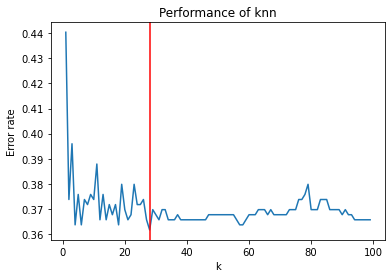

In [25]:
krd_data_train1 = krd_data_train.drop(['participant_id', 'collect_period'], axis=1)

krd_err = []
kclc = range(1,100)

for k in kclc:
    krd_pred, _ = myKNN(mytrain=krd_data_train1, mytrainlabel=meta_data_train['was_preterm'], mytest=krd_data_valid, myK=k)
    krd_err.append(np.mean(krd_pred != meta_data_valid['was_preterm']))
    
# mytrain_K = np.argmin(krd_err)
mytrain_K = np.argmin(krd_err) + 1
print(mytrain_K)

# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(kclc, krd_err)
ax.set(xlabel="k",
       ylabel="Error rate",
       title="Performance of knn")
plt.axvline(x=mytrain_K, color = 'r')
plt.show()

In [26]:
# mytrain_K = 30

## 2.8. Second-stage logistic regression model

In [27]:
def evaluate(model, myinput, myoutput, cutoff=0.5):
    
    model.eval()
    
    # predicted labels
    myinput  = torch.from_numpy(myinput).float().to(device)
    myoutput_nn, hidden = model(myinput)
    myoutput_nn = myoutput_nn.reshape((myoutput.shape))
    output_prob = nn.functional.softmax(myoutput_nn, dim=2)
    mypredprob = output_prob[:,3,0].cpu().detach().numpy()
    mypred = 1*(mypredprob > cutoff)

    # observed labels
    myobs  = myoutput[:,3,0]
    
    return myobs, mypred, mypredprob

In [28]:
phylotype_obs, phylotype_pred, phylotype_prob = evaluate(model=model_phylotype, myinput=phylotypetrain_input, myoutput=mytrain_output_0, cutoff=0.5)
taxonomy_obs, taxonomy_pred, taxonomy_prob = evaluate(model=model_taxonomy, myinput=taxonomytrain_input, myoutput=mytrain_output_0, cutoff=0.5)
meta_obs, meta_pred, meta_prob = evaluate(model=model_meta, myinput=metatrain_input, myoutput=mytrain_output_0, cutoff=0.5)

In [29]:
_, krd_prob = myKNN(mytrain=krd_data_train1, mytrainlabel=meta_data_train['was_preterm'], mytest=krd_data_train1, myK=mytrain_K)

krd_prob = pd.DataFrame({
    'participant_id': meta_data_train['participant_id'],
    'collect_period': meta_data_train['collect_period'],
    'krd_prob': krd_prob
})

krd_prob_wide = krd_prob.pivot_table(index=['participant_id'], columns='collect_period', values='krd_prob')
# last period probability as final probability
krd_prob = np. array(krd_prob_wide.fillna(method='ffill', axis=1).iloc[:, -1])

In [30]:
x = np.array(np.transpose([phylotype_prob, taxonomy_prob, krd_prob, meta_prob])).reshape(-1, 4)

Logistic_model = LogisticRegression(solver='liblinear').fit(x, phylotype_obs)
# Logistic_model.predict_proba(x)
# Logistic_model.predict(x)

# 3. Test model performance

Test set prior probability of class "preterm".

In [31]:
testprior = sum(phylotype_obs)/len(phylotype_obs)
print(testprior)

0.30727023319615915


## 3.1 First stage model AUC

#### phylotype data

In [32]:
phylotype_obs, phylotype_pred, phylotype_prob = evaluate(model=model_phylotype, myinput=phylotypetest_input, myoutput=mytest_output_0, cutoff=0.5)
print(metrics.roc_auc_score(phylotype_obs, phylotype_prob))
confusion = metrics.confusion_matrix(phylotype_obs, phylotype_pred)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

0.7156529793146033
[[79  0]
 [41  0]]


#### taxonomy data

In [33]:
taxonomy_obs, taxonomy_pred, taxonomy_prob = evaluate(model=model_taxonomy, myinput=taxonomytest_input, myoutput=mytest_output_0, cutoff=0.5)
print(metrics.roc_auc_score(taxonomy_obs, taxonomy_prob))
confusion = metrics.confusion_matrix(taxonomy_obs, taxonomy_pred)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

0.7675208397653597
[[70  9]
 [22 19]]


#### meta data

In [34]:
meta_obs, meta_pred, meta_prob = evaluate(model=model_meta, myinput=metatest_input, myoutput=mytest_output_0, cutoff=0.5)
print(metrics.roc_auc_score(meta_obs, meta_prob))
confusion = metrics.confusion_matrix(meta_obs, meta_pred)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

0.6900277863538129
[[72  7]
 [27 14]]


#### krd distance data

In [35]:
krd_pred, krd_prob = myKNN(mytrain=krd_data_train1, mytrainlabel=meta_data_train['was_preterm'], mytest=krd_data_test, myK=mytrain_K)
krd_pred_data = pd.DataFrame({
    'participant_id': meta_data_test['participant_id'],
    'collect_period': meta_data_test['collect_period'],
    'krd_obs': meta_data_test['was_preterm'],
    'krd_prob': krd_prob,
    'krd_pred': krd_pred
})

krd_obs = krd_pred_data.pivot_table(index=['participant_id'], columns='collect_period', values='krd_obs')
# last period probability as final probability
krd_obs = np. array(krd_obs.fillna(method='ffill', axis=1).iloc[:, -1])

krd_prob = krd_pred_data.pivot_table(index=['participant_id'], columns='collect_period', values='krd_prob')
# last period probability as final probability
krd_prob = np. array(krd_prob.fillna(method='ffill', axis=1).iloc[:, -1])

krd_pred = krd_pred_data.pivot_table(index=['participant_id'], columns='collect_period', values='krd_pred')
# last period probability as final probability
krd_pred = np. array(krd_pred.fillna(method='ffill', axis=1).iloc[:, -1])

In [36]:
print(metrics.roc_auc_score(krd_obs, krd_prob))
confusion = metrics.confusion_matrix(krd_obs, krd_pred)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

0.4016671812287743
[[77  2]
 [40  1]]


## 3.2. Second stage model AUC

In [37]:
x = np.array(np.transpose([phylotype_prob, taxonomy_prob, krd_prob, meta_prob])).reshape(-1, 4)
final_obs = meta_obs
final_prob = Logistic_model.predict_proba(x)[:,1]
final_pred = Logistic_model.predict(x)

print(metrics.roc_auc_score(final_obs, final_prob))

confusion = metrics.confusion_matrix(final_obs, final_pred)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

0.7585674590923125
[[68 11]
 [23 18]]


# 4. Comments

- Re-train the obtained proability from the first stage model did improve the performance in terms of AUC value;
- Every LSTM same structure or preform parameter tunning;
- Need to split training/validation/testing set project-wise;

# 5. Study materials

### How to use Learning Curves to Diagnose Machine Learning Model Performance

Study materials:
https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

A plot of learning curves shows **Underfitting** if:
- The training loss remains flat regardless of training;
- The training loss continues to decrease untill the end of training;

A plot of learning curves shows **Overfitting** if:
- The training loss continues to decrease with experience;
- The validation loss decreases to a point and begins increasing again;

A plot of learning curves shows **Goodfitting** if:
- The plot of training loss decreases to a point of stability;
- The plot of validation loss decreases to a point of stability and has a small gap with the training loss;

A plot of learning curves shows **Unrepresentative training set** if:
- The plot of training loss shows improvement;
- The plot of validation loss shows improvement, but a large gap between two curves;

A plot of learning curves shows **Unrepresentative validation set** if:
- The plot of training loss shows goodfit;
- The plot of validation loss shows noisy movement around the training loss;
- The validation loss is lower than the training loss;

### Why the training loss is above the validation loss?

- Regularization is applied during training, but not during validation. If add in the regularization loss during validation, your loss values and curves will look more similar;
- Training loss is measured during each epoch while validation loss is measured after each epoch. On average, the training loss is measured 1/2 an epoch earlier. If you shift your training loss curve a half epoch to the left, your losses will align a bit better;
- Your validation set may be easier than your training set or there is a leak in your data/bug in your code. Make sure your validation set is reasonably large and is sampled from the same distribution (and difficulty) as your training set;
- You may be over-regularizing your model. Try reducing your regularization constraints, including increasing your model capacity (i.e., making it deeper with more parameters), reducing dropout, reducing L2 weight decay strength, etc;

**Reason**: 

The training loss is calculated within each batch and adding together, which is different from the calculation method of validation set. Align the calculation method for each epoch will make the loss function values comparable and reasonable.